In [30]:
"""The purpose of this script is to store the customisable framework that includes adjustable parameters and uses tools
from scikit-learn for supervised learning and visualization for the machine learning aspect in assignment 2 of SCIE3100.
"""
#######################################################################################################################
# Section 0 - House-keeping modules and functions #
#######################################################################################################################
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def load_data(file_path):
    # Load the data using Pandas (adjust the delimiter if needed)
    data = pd.read_csv(file_path, index_col=0)

    # Extract features (all columns except the label column)
    X = data.drop(columns=['Label'])  # Replace 'Label' with the actual label column name

    # Extract labels (assuming the label column name is 'Label')
    y = data['Label'].values
    
    labelencoder = LabelEncoder() #transform the y values to 0 or 1
    encoded_Y = LabelEncoder().fit_transform(y) #as previous

    return X, encoded_Y

In [31]:
# Loading files
mrna_file_path = "G1/G1_breast_gene-expr.csv"
methyl_file_path = "G1/G1_breast_dna-meth.csv"

mrna_X, mrna_y = load_data(mrna_file_path)
methyl_X, methyl_y = load_data(methyl_file_path)

# Irrelevant at the moment
real_mrna_data = "G1/mystery_gene-expr.csv"
real_methyl_data = "G1/mystery_dna-meth.csv"

real_mrna_X, real_mrna_y = load_data(real_mrna_data)
real_methyl_X, real_methyl_y = load_data(real_methyl_data)

# Impute NaN values with 0
real_mrna_X = real_mrna_X.fillna(0)
real_methyl_X = real_methyl_X.fillna(0)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print (f'Original mrna X train shape is {mrna_X.shape}, methyl X train shape is {methyl_X.shape}')
mrna_X_train, mrna_X_test, mrna_y_train, mrna_y_test = train_test_split(mrna_X, mrna_y, test_size=0.30, random_state=42) #splite the data into training and testing set
methyl_X_train, methyl_X_test, methyl_y_train, methyl_y_test = train_test_split(methyl_X, methyl_y, test_size=0.30, random_state=42) #splite the data into training and testing set

# Actual inplementation for assignment, comment this to predict breast cancer
mrna_X_train, mrna_X_test, mrna_y_train, mrna_y_test = mrna_X, real_mrna_X, mrna_y, real_mrna_y
methyl_X_train, methyl_X_test, methyl_y_train, methyl_y_test = methyl_X, real_methyl_X, methyl_y, real_methyl_y

print (f'mrna data - X train shape: {mrna_X_train.shape}, y train shape: {mrna_y_train.shape}, X test shape is {mrna_X_test.shape}, y test shape is {mrna_y_test.shape}')
print (f'methyl data -X train shape: {methyl_X_train.shape}, y train shape: {methyl_y_train.shape}, X test shape is {methyl_X_test.shape}, y test shape is {methyl_y_test.shape}')

Original mrna X train shape is (1205, 20531), methyl X train shape is (880, 5000)
mrna data - X train shape: (1205, 20531), y train shape: (1205,), X test shape is (380, 20821), y test shape is (380,)
methyl data -X train shape: (880, 5000), y train shape: (880,), X test shape is (380, 18091), y test shape is (380,)


In [33]:
#######################################################################################################################
# Section 2 - Feature Selection #
#######################################################################################################################
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy
from sklearn.model_selection import GridSearchCV

def rf_selector(X_train, y_train):
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=10)
    rf.fit(X_train, y_train)
    
    # Retrieve and sort the features by importance in descending order
    importances = rf.feature_importances_
    
    # Visualize importances for features and print out the gene names
    sorted_indices = importances.argsort()[::-1] 
    non_zero_indices = sorted_indices[importances[sorted_indices] > 0]
    features_names = X_train.columns.tolist()
    
    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(non_zero_indices)), importances[non_zero_indices])
    plt.xticks(range(len(non_zero_indices)), [features_names[i] for i in non_zero_indices], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Feature Importances from RandomForestClassifier")
    plt.tight_layout()
    plt.show()
    
    top_10_features = "Top 10 features: "
    for index in non_zero_indices[0:10]:
        top_10_features += f'{features_names[index]}\t'
    #     print(f"{features_lst[idx]}: {importances[idx]}")
    print(top_10_features)
    
    # Select the features to trim the dataset
    feature_selector = SelectFromModel(rf, threshold=0.01)
    selected_X = feature_selector.fit_transform(X_train.values, y_train)
    selected_X = pd.DataFrame(selected_X, columns=X_train.columns[feature_selector.get_support()])
    
    return selected_X

def rf_selector(X_train, y_train):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    
    # Set paramters combinations to loop over
    reduction_rf_params = {
        'n_estimators': [70, 85, 100],
#         'random_state': [42],  # Random state for reproducibility (seed)
        'verbose': [0],
        'max_depth': [None, 10, 15, 20, 25, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    }   
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=reduction_rf_params,
        cv=5,
        scoring='f1',
    )
    
    grid_search.fit(X_train.values, y_train)
    
    # Get the best estimator with the best hyperparameters
    best_rf = grid_search.best_estimator_
    print(f"best_rf: {best_rf}")
    
    # Retrieve and sort the features by importance in descending order
    importances = best_rf.feature_importances_
    
    # Visualize importances for features and print out the gene names
    sorted_indices = importances.argsort()[::-1] 
    non_zero_indices = sorted_indices[importances[sorted_indices] > 0]
    features_names = X_train.columns.tolist()
    
    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(non_zero_indices)), importances[non_zero_indices])
    plt.xticks(range(len(non_zero_indices)), [features_names[i] for i in non_zero_indices], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Feature Importances from RandomForestClassifier")
    plt.tight_layout()
    plt.show()
    
    top_10_features = "Top 10 features: "
    for index in non_zero_indices[0:10]:
        top_10_features += f'{features_names[index]}\t'
    #     print(f"{features_lst[idx]}: {importances[idx]}")
    print(top_10_features)
    
    # Select the features to trim the dataset
    feature_selector = SelectFromModel(rf, threshold=0.01)
    selected_X = feature_selector.fit_transform(X_train.values, y_train)
    selected_X = pd.DataFrame(selected_X, columns=X_train.columns[feature_selector.get_support()])
    
    return selected_X


def boruta_selector(X_train, y_train):
    # Create a random forest classifier
    forest = RandomForestClassifier()
    forest.fit(X_train.values, y_train)

    # Initialize Boruta
#     boruta_rf = BorutaPy(forest, n_estimators='auto', random_state=42)
    boruta_rf = BorutaPy(forest, n_estimators='auto')
    boruta_rf.fit(X_train.values, y_train)
    
    # Create a mask of selected features
    feature_mask = boruta_rf.support_

    # Extract the selected feature names
    selected_feature_names = X_train.columns[feature_mask]

    # Create a new DataFrame with only the selected features
    X_selected = X_train[selected_feature_names]

    return X_selected

best_rf: RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       n_estimators=70, random_state=42)


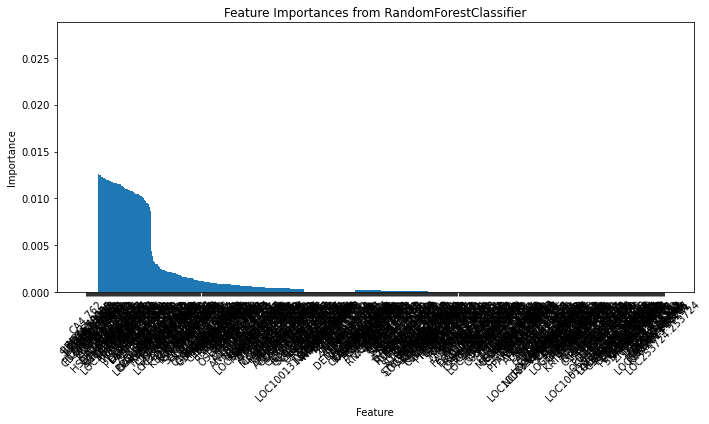

Top 10 features: CA4.762	RERGL.79785	SLC35A2.7355	HOXA5.3202	H2AFY.9555	LMOD1.25802	MATN2.4147	ITIH5.80760	CD300LG.146894	PCDHGB7.56099	

mrna data - X train reduced shape: (1205, 9), X test reduced shape is (380, 9)


In [34]:
mrna_reduced_X = rf_selector(mrna_X_train, mrna_y_train)
mrna_X_test = mrna_X_test[mrna_reduced_X.columns]
print (f'\nmrna data - X train reduced shape: {mrna_reduced_X.shape}, X test reduced shape is {mrna_X_test.shape}')

best_rf: RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       min_samples_split=10, random_state=42)


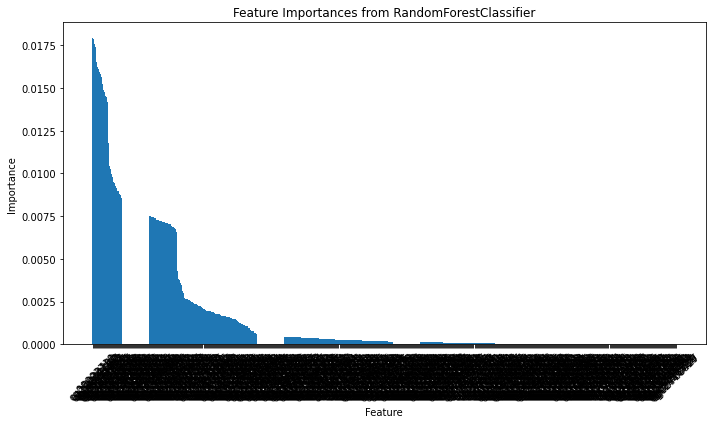

Top 10 features: cg00002719	cg25025181	cg17034390	cg25691167	cg23302649	cg24886257	cg26765743	cg26354493	cg10940462	cg08047907	

methyl data - X train reduced shape: (880, 14), X test reduced shape is (380, 14)


In [35]:
methyl_reduced_X = rf_selector(methyl_X_train, methyl_y_train)
methyl_X_test = methyl_X_test[methyl_reduced_X.columns]
print (f'\nmethyl data - X train reduced shape: {methyl_reduced_X.shape}, X test reduced shape is {methyl_X_test.shape}')

In [36]:
#######################################################################################################################
# Section 3 - Classification #
#######################################################################################################################
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


def rf_predict_heatmap(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier()
    
    # Set paramters combinations to loop over
    reduction_rf_params = {
        'n_estimators': [70, 85, 100],
#         'random_state': [42],  # Random state for reproducibility (seed)
        'verbose': [0],
        'max_depth': [None, 10, 15, 20, 25, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    }   
    
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=reduction_rf_params,
        cv=5,
        scoring='f1',
    )
    
    grid_search.fit(X_train.values, y_train)
    
    # Get the best estimator with the best hyperparameters
    rf_classifier = grid_search.best_estimator_
    rf_classifier.fit(X_train, y_train)
    predictions = rf_classifier.predict(X_test)
    
    print(rf_classifier)
    print ("Accuracy: ", metrics.accuracy_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions, average='macro'))

    # Confusion Matrix - verify accuracy of each class
    cm = confusion_matrix(y_test, predictions)
    class_labels = ["Tumor", "Normal tissue"]

    # Set the color map to "viridis" (a popular color map)
    cmap = sns.color_palette("viridis", as_cmap=True)

    # Create a larger figure for better visualization
    plt.figure(figsize=(8, 6))

    # Plot the confusion matrix as a heatmap with annotations
    sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel("Predicted")
    plt.ylabel("Reality")
    plt.title("Confusion Matrix")

    # Show the heatmap
    plt.show()

RandomForestClassifier(min_samples_leaf=4, random_state=42)
Accuracy:  0.6447368421052632
F1 Score: 0.5934218347533188


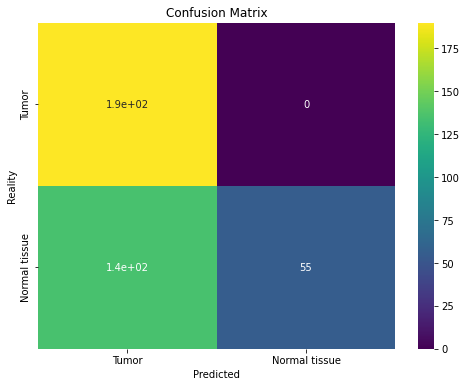

In [37]:
rf_predict_heatmap(mrna_reduced_X, mrna_y_train, mrna_X_test, mrna_y_test)

RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=85, random_state=42)
Accuracy:  0.6394736842105263
F1 Score: 0.5891437996701154


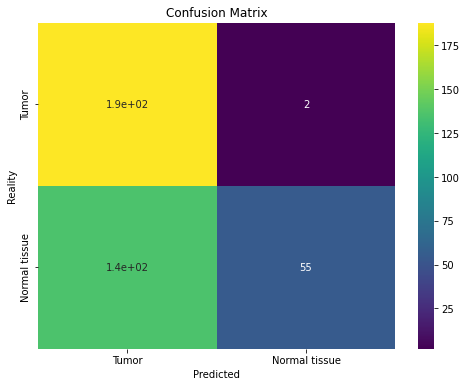

In [38]:
rf_predict_heatmap(methyl_reduced_X, methyl_y_train, methyl_X_test, methyl_y_test)

In [39]:
from sklearn.tree import DecisionTreeClassifier

def dt_predict_heatmap(X_train, y_train, X_test, y_test):
    dt_classifier = DecisionTreeClassifier(max_depth=25)
    dt_classifier.fit(X_train, y_train)
    
    predictions = dt_classifier.predict(X_test)

    print(dt_classifier)
    print ("Accuracy: ", metrics.accuracy_score(y_test, predictions))
    print("F1 Score:", f1_score(y_test, predictions, average='macro'))

    # Confusion Matrix - verify accuracy of each class
    cm = confusion_matrix(y_test, predictions)
    class_labels = ["Tumor", "Normal tissue"]

    # Set the color map to "viridis" (a popular color map)
    cmap = sns.color_palette("viridis", as_cmap=True)

    # Create a larger figure for better visualization
    plt.figure(figsize=(8, 6))

    # Plot the confusion matrix as a heatmap with annotations
    sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel("Predicted")
    plt.ylabel("Reality")
    plt.title("Confusion Matrix")

    # Show the heatmap
    plt.show()

DecisionTreeClassifier(max_depth=25)
Accuracy:  0.6894736842105263
F1 Score: 0.6610733182161753


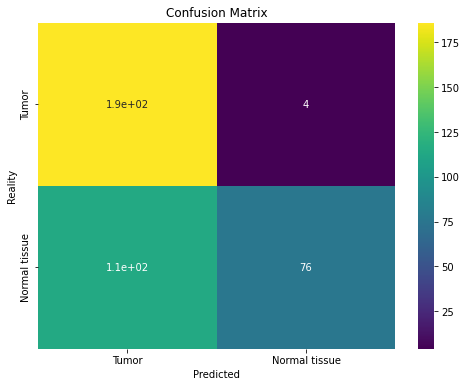

In [40]:
dt_predict_heatmap(mrna_reduced_X, mrna_y_train, mrna_X_test, mrna_y_test)

DecisionTreeClassifier(max_depth=25)
Accuracy:  0.8236842105263158
F1 Score: 0.8230359141175081


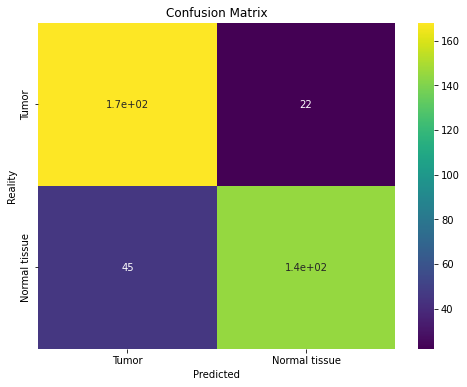

In [41]:
dt_predict_heatmap(methyl_reduced_X, methyl_y_train, methyl_X_test, methyl_y_test)

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.linear_stack= nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = self.linear_stack(x)
        return x

def neural_predict_heatmap(X_train, y_train, X_test, y_test):

    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 

    num_samples = X_train_tensor.shape[0]
    input_size = X_train_tensor.shape[1]
    hidden_size = 4
    num_classes = len(set(y_train))
    
    print(f"num_samples: {num_samples}, input_size {input_size}, hidden_size {hidden_size}, num_classes {num_classes}")
    
    model = NeuralNetwork(input_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    epochs = 100000

    # Training loop
    for epoch in range(epochs):
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor.long()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if (epoch + 1) % 100 == 0:
#             print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Test the model and calculate accuracy and F1 score
    with torch.inference_mode():
        y_pred = model(X_test_tensor)
        predicted_classes = torch.argmax(y_pred, dim=1)
        accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy())
        f1 = f1_score(y_test_tensor.numpy(), predicted_classes.numpy(), average='macro')

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

    # Create a confusion matrix
    cm = confusion_matrix(y_test, predicted_classes)
    class_labels = ["Tumor", "Normal tissue"]

    # Set the color map to "viridis" (a popular color map)
    cmap = sns.color_palette("viridis", as_cmap=True)

    # Create a larger figure for better visualization
    plt.figure(figsize=(8, 6))

    # Plot the confusion matrix as a heatmap with annotations
    sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)

    # Add labels and title
    plt.xlabel("Predicted")
    plt.ylabel("Reality")
    plt.title("Confusion Matrix")

    # Show the heatmap
    plt.show()

num_samples: 1205, input_size 9, hidden_size 4, num_classes 2
Accuracy: 0.5
F1 Score: 0.3333333333333333


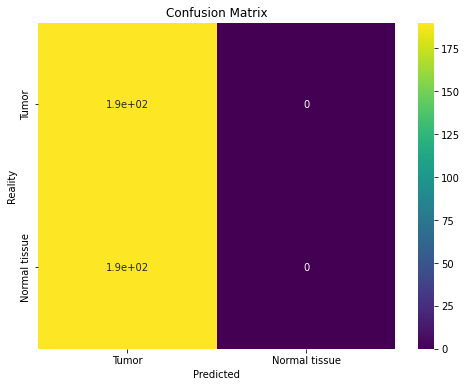

In [43]:
neural_predict_heatmap(mrna_reduced_X, mrna_y_train, mrna_X_test, mrna_y_test)

num_samples: 880, input_size 14, hidden_size 4, num_classes 2
Accuracy: 0.8736842105263158
F1 Score: 0.8725402504472272


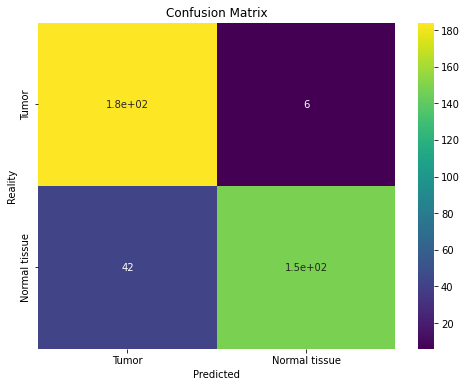

In [44]:
neural_predict_heatmap(methyl_reduced_X, methyl_y_train, methyl_X_test, methyl_y_test)

In [45]:
#######################################################################################################################
# Section 4 - Boruta reduction and repeat everything else #
#######################################################################################################################

In [46]:
# Actual inplementation for assignment, comment this to predict breast cancer
mrna_X_train, mrna_X_test, mrna_y_train, mrna_y_test = mrna_X, real_mrna_X, mrna_y, real_mrna_y
methyl_X_train, methyl_X_test, methyl_y_train, methyl_y_test = methyl_X, real_methyl_X, methyl_y, real_methyl_y

In [47]:
mrna_reduced_X = boruta_selector(mrna_X_train, mrna_y_train)
mrna_X_test = mrna_X_test[mrna_reduced_X.columns]
print (f'\nmrna data - X train reduced shape: {mrna_reduced_X.shape}, X test reduced shape is {mrna_X_test.shape}')


mrna data - X train reduced shape: (1205, 500), X test reduced shape is (380, 500)


In [48]:
methyl_reduced_X = boruta_selector(methyl_X_train, methyl_y_train)
methyl_X_test = methyl_X_test[methyl_reduced_X.columns]
print (f'\nmethyl data - X train reduced shape: {methyl_reduced_X.shape}, X test reduced shape is {methyl_X_test.shape}')


methyl data - X train reduced shape: (880, 250), X test reduced shape is (380, 250)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=4,
                       n_estimators=70, random_state=42)
Accuracy:  0.6131578947368421
F1 Score: 0.5450806655210887


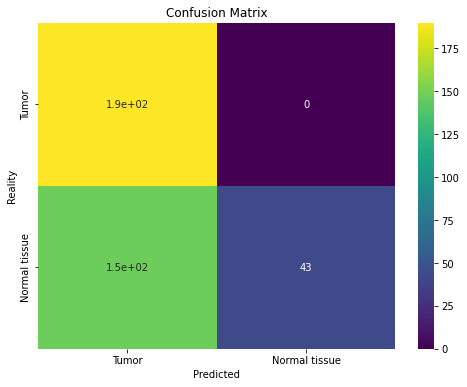

In [49]:
rf_predict_heatmap(mrna_reduced_X, mrna_y_train, mrna_X_test, mrna_y_test)

RandomForestClassifier(class_weight='balanced', n_estimators=70,
                       random_state=42)
Accuracy:  0.6
F1 Score: 0.5238095238095238


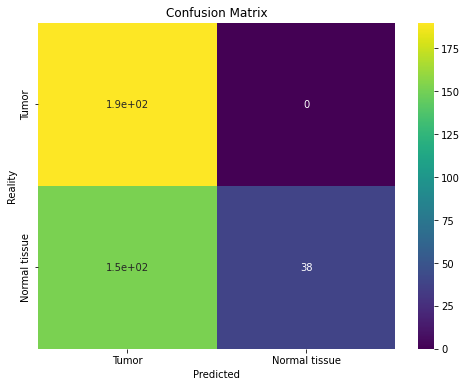

In [50]:
rf_predict_heatmap(methyl_reduced_X, methyl_y_train, methyl_X_test, methyl_y_test)

num_samples: 1205, input_size 500, hidden_size 4, num_classes 2
Accuracy: 0.5
F1 Score: 0.3333333333333333


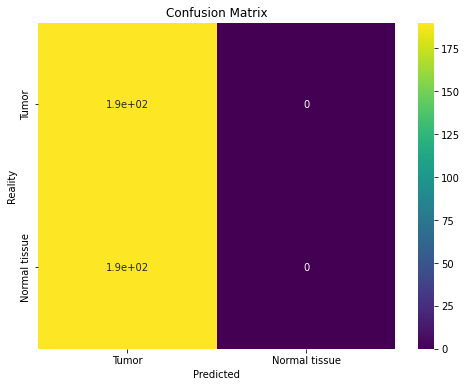

In [51]:
neural_predict_heatmap(mrna_reduced_X, mrna_y_train, mrna_X_test, mrna_y_test)

num_samples: 880, input_size 250, hidden_size 4, num_classes 2
Accuracy: 0.8473684210526315
F1 Score: 0.8472626472626472


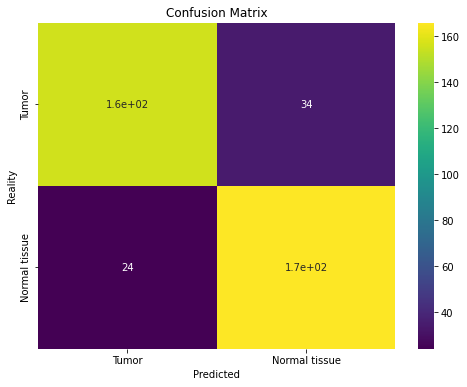

In [52]:
neural_predict_heatmap(methyl_reduced_X, methyl_y_train, methyl_X_test, methyl_y_test)

In [53]:
# Actual inplementation for assignment, comment this to predict breast cancer
mrna_X_train, mrna_X_test, mrna_y_train, mrna_y_test = mrna_X, real_mrna_X, mrna_y, real_mrna_y
methyl_X_train, methyl_X_test, methyl_y_train, methyl_y_test = methyl_X, real_methyl_X, methyl_y, real_methyl_y

mrna_X_test = mrna_X_test[mrna_reduced_X.columns]
methyl_X_test = methyl_X_test[methyl_reduced_X.columns]


In [54]:
#######################################################################################################################
# Section 4 - 100 runs #
#######################################################################################################################


DecisionTreeClassifier(max_depth=25)
Accuracy:  0.718421052631579
F1 Score: 0.7093866815332603


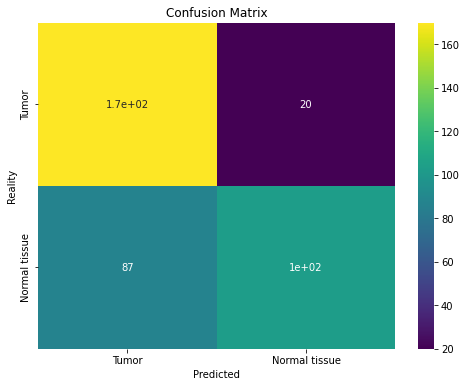

In [55]:
dt_predict_heatmap(mrna_reduced_X, mrna_y_train, mrna_X_test, mrna_y_test)

DecisionTreeClassifier(max_depth=25)
Accuracy:  0.6947368421052632
F1 Score: 0.6645459803354541


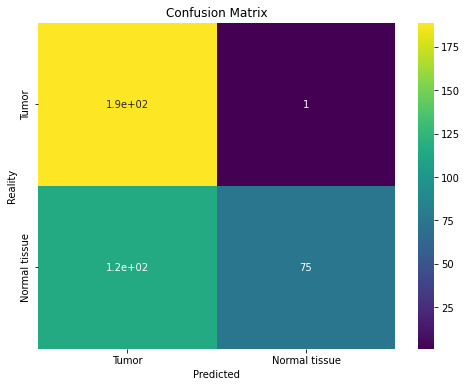

In [56]:
dt_predict_heatmap(methyl_reduced_X, methyl_y_train, methyl_X_test, methyl_y_test)

In [57]:
mrna_reduced_X.columns


Index(['ABCA10.10349', 'ABCA5.23461', 'ABCA6.23460', 'ABCA8.10351',
       'ABCA9.10350', 'ABCB1.5243', 'ABCB5.340273', 'ABLIM1.3983', 'ACACB.32',
       'ACSM5.54988',
       ...
       'UHRF1.29128', 'UNC5B.219699', 'USHBP1.83878', 'USP44.84101',
       'UTRN.7402', 'VIT.5212', 'WDR62.284403', 'WISP1.8840', 'ZC3H12B.340554',
       'ZWINT.11130'],
      dtype='object', length=500)